In [1]:
# import torch
# from torch import nn
# import matplotlib.pyplot as plt
# from torchvision.utils import make_grid
# from PIL import Image
# from skimage import data, io
# from tqdm.auto import tqdm
import torch
import torch.nn as nn
from tqdm.auto import tqdm
from torchvision.utils import make_grid
from torch.utils.data import random_split
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import models, transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
import cv2
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from fastai.vision.all import show_image

In [2]:
class conv_block(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(conv_block,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,3,1,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_channels,out_channels,3,1,1,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )
    def forward(self,x):
        return self.model(x)
class conv_transpose_block(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(conv_transpose_block, self).__init__()
        
        self.model = nn.Sequential( 
                         nn.ConvTranspose2d(in_channels, out_channels, 2, 2, bias=False),
                         nn.InstanceNorm2d(out_channels),
                         nn.ReLU(inplace=True),
                    )

    def forward(self, x, skip_input,i):
        # print(i)
        x = self.model(x)
        # print(x.shape)
        # print(skip_input.shape)
        x = torch.cat((x, skip_input), 1)
        return x

class UNET(nn.Module):
    def __init__(self,in_channels=3,out_channels=3):
        super(UNET,self).__init__()
        self.pool = nn.MaxPool2d(2,2)
        self.c1 = conv_block(in_channels,64)
        self.c2 = conv_block(64,128)
        self.c3 = conv_block(128,256)
        self.c4 = conv_block(256,512)
        self.c5 = conv_block(512,1024)
        self.ct1 = conv_transpose_block(1024,512)
        self.c6 = conv_block(1024,512)
        self.ct2 = conv_transpose_block(512,256)
        self.c7 = conv_block(512,256)
        self.ct3 = conv_transpose_block(256,128)
        self.c8 = conv_block(256,128)
        self.ct4 = conv_transpose_block(128,64)
        self.c9 = conv_block(128,64)
        self.final = nn.Conv2d(64,out_channels,1)
            
    def forward(self,x):
        l1 = self.c1(x) # channels:64
        l2 = self.pool(l1)# size:256
        l3 = self.c2(l2)# channels:128
        l4 = self.pool(l3)# size:128 
        l5 = self.c3(l4)# channels:256
        l6 = self.pool(l5)# size:64
        l7 = self.c4(l6)# channels:512
        l8 = self.pool(l7)# size:32
        l9 = self.c5(l8)# channels:1024 
        l10 = self.ct1(l9,l7,1)# size:64 
        l11 = self.c6(l10)# channels:512
        l12 = self.ct2(l11,l5,2)# size:128
        l13 = self.c7(l12)# channels:256
        l14 = self.ct3(l13,l3,3)# size:256
        l15 = self.c8(l14)# channels:128
        l16 = self.ct4(l15,l1,4)# size:512
        l17 = self.c9(l16)# channels:64
        l18 = self.final(l17)# size:512 channels:3
        return l18

In [3]:
def test_generator():
    x = torch.randn((1,3,256,512))
    model = UNET()
    preds = model(x)
    print("test")
    print(x.shape)
    print(preds.shape)
test_generator()

test
torch.Size([1, 3, 256, 512])
torch.Size([1, 3, 256, 512])


In [4]:
Normalization_Values = (0.0,0.0,0.0),(1.0,1.0,1.0)
def DeNormalize(tensor_of_image):
  return tensor_of_image * Normalization_Values[1][0] + Normalization_Values[0][0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<AxesSubplot:>

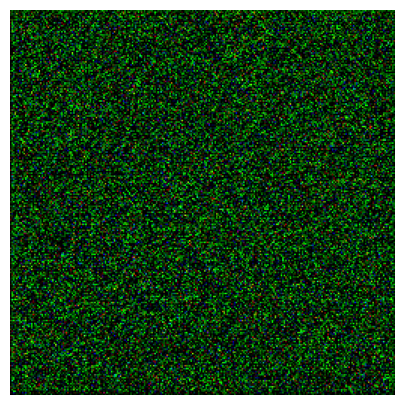

In [5]:
x = torch.randn((1,3,256,256))
model = UNET()
preds = model(x)
show_image(preds[0])

In [6]:
#This code is used to seperate image
generate_data = False
if generate_data:
    img_dir = r"D:\dataset\cityscapes\cityscapes\val"
    image_dir = r"D:\dataset\cityscapes\cityscapes\images"
    masks_dir = r"D:\dataset\cityscapes\cityscapes\masks"
    for i in tqdm(range(1,2976)):
        path=str(i)+'.png'
        img= io.imread(f"{img_dir}\\{i}.jpg")
        img1 = img[:,:256,:]
        img2 = img[:,256:,:]
        # print(img1.shape,img2.shape)
        io.imsave(f"{image_dir}\\image_{i}.jpg",img1)
        io.imsave(f"{masks_dir}\\mask_{i}.jpg",img2)


In [7]:
# image_dir = r"D:\dataset\cityscapes\cityscapes\images"
# masks_dir = r"D:\dataset\cityscapes\cityscapes\masks"
data_transform = transforms.Compose([
    # transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Resize((256, 512)),
    transforms.Normalize( mean=[0.0, 0.0, 0.0],
                std=[1.0, 1.0, 1.0]),
    
])
# images = ImageFolder(image_dir, transform=data_transform)
# mask = ImageFolder(masks_dir, transform=data_transform)

# image_dl = DataLoader(images, batch_size, num_workers=4, pin_memory=True)
# mask_dl   = DataLoader(mask  , batch_size, num_workers=4, pin_memory=True)
batch_size=1
data_dir = r"D:\dataset\cityscapes\cityscapes\train"
data = ImageFolder(data_dir, transform=data_transform)
data_dl = DataLoader(data, batch_size, num_workers=4, pin_memory=True)

In [9]:
LEARNING_RATE = 1e-4
DEVICE = 'cuda'
FILE = "segmentation_model_200.pth"
model = UNET(in_channels=3, out_channels=3).to('cuda')
model.load_state_dict(torch.load(FILE))
model.eval()
# model = UNET(in_channels=3, out_channels=3).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

In [10]:
def print_images(image_tensor, num_images):
    print('reached')
    images = DeNormalize(image_tensor)
    images = images.detach().cpu()
    image_grid = make_grid(images[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [11]:
class diceloss(torch.nn.Module):
    def init(self):
        super(diceLoss, self).init()
    def forward(self,pred, target):
       smooth = 1.
       iflat = pred.contiguous().view(-1)
       tflat = target.contiguous().view(-1)
       intersection = (iflat * tflat).sum()
       A_sum = torch.sum(iflat * iflat)
       B_sum = torch.sum(tflat * tflat)
       return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))
criterion = diceloss()

In [13]:
def train_fn(epochs):
    e_loss = []
    accuracy = []
    for i in range(epochs):
        epoch_loss = 0
        total_train = 0
        correct_train = 0
        train_accuracy  = 0
        for images,_ in tqdm(data_dl):
            data = images[:,:,:,:256].to(DEVICE)
            target= images[:,:,:,256:].to(DEVICE)
            # forward
            with torch.cuda.amp.autocast():
                predictions = model(data)
                predictions = predictions.to(torch.float32)
                loss = criterion(predictions, target)
            epoch_loss += loss.item()
            # print('train_accuracy',train_accuracy)
            # backward
            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        e_loss.append(epoch_loss)
        accuracy.append(train_accuracy)
        # print_images(data,5)
        # print_images(target,5)
        print_images(predictions,5)
        print(f"epoch: {i}, loss:{epoch_loss}, acc:{train_accuracy}")
    return epoch_loss
            

In [14]:
# epochs = 50
# train_fn(epochs)

In [15]:
# epochs = 80
# losses = train_fn(epochs)

In [16]:
batch_size=1
data_dir = r"D:\dataset\cityscapes\cityscapes\val"
val = ImageFolder(data_dir, transform=data_transform)
val_dl = DataLoader(val, batch_size, num_workers=4, pin_memory=True)

In [17]:
# with torch.no_grad():
#     i = 0
#     for images,_ in tqdm(val_dl):
#             data = images[:,:,:,:256].to(DEVICE)
#             target= images[:,:,:,256:].to(DEVICE)
#             pred = model(data)
#             # print_images(data,5)
#             print_images(target,5)
#             print_images(pred,5)
#             if i == 5:
#                 break
#             i += 1
            
        

In [18]:
# FILE = "segmentation_model_200.pth"
# torch.save(model.state_dict(),FILE)

In [20]:
# FILE = "model.pth"
FILE = "segmentation_model_200.pth"
load_model = UNET(in_channels=3, out_channels=3)
load_model.load_state_dict(torch.load(FILE))
load_model.eval()

UNET(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c1): conv_block(
    (model): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.2)
    )
  )
  (c2): conv_block(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, a

In [21]:
def accuracy_check(mask, prediction):
    ims = [mask, prediction]
    np_ims = []
    for item in ims:
        if 'str' in str(type(item)):
            print("instr")
            item = np.array(Image.open(item))
        elif 'PIL' in str(type(item)):
            print("inpil")
            item = np.array(item)
        elif 'torch' in str(type(item)):
            print("torch")
            item = item.numpy()
        np_ims.append(item)
    print(np_ims[0])
    print(np_ims[1])
    compare = np.equal(np_ims[0], np_ims[1])
    print(compare)
    accuracy = np.sum(compare)
    print(accuracy)
    return accuracy/len(np_ims[0].flatten())

In [142]:
with torch.no_grad():
    for images,_ in val_dl:
            data = images[:,:,:,:256]
            target= images[:,:,:,256:]
            # print(data)
            pred = load_model(data.float())
            # print_images(data,5)
            # print_images(target,5)
            # print_images(pred,5)
            # acc = accuracy_check(target,pred)
            preds = torch.argmax(pred, 1)
            acc = preds.eq(target).float().mean()
            # _, predicted = torch.max(pred, 1)
            # total_train += target.size(0)
            # correct_train += predicted.eq(target).sum().item()
            # train_accuracy = 100 * correct_train / total_train
            
            print(acc)
            break

tensor(0.0072)


In [22]:
def print_images_1(images, num_images):
    print('reached')
    # images = DeNormalize(image_tensor)
    images = images.detach().cpu()
    image_grid = make_grid(images[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [28]:
# epochs = 1
# losses = train_fn(epochs)